## ☁️ Connect G-Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Homework 2 AN2DL condivisa

Mounted at /gdrive
/gdrive/My Drive/Homework 2 AN2DL condivisa


In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

!pip install focal-loss

from focal_loss import SparseCategoricalFocalLoss

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## 📊 Load data (no 👽)

In [3]:
data = np.load("Datasets/Dataset_cleaned.npz")
training_set = data["training_set"]

X_train = training_set[0, :]
y_train = training_set[1, :]

X_test = data["test_set"]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(2505, 64, 128)
(2505, 64, 128)
(10022, 64, 128)


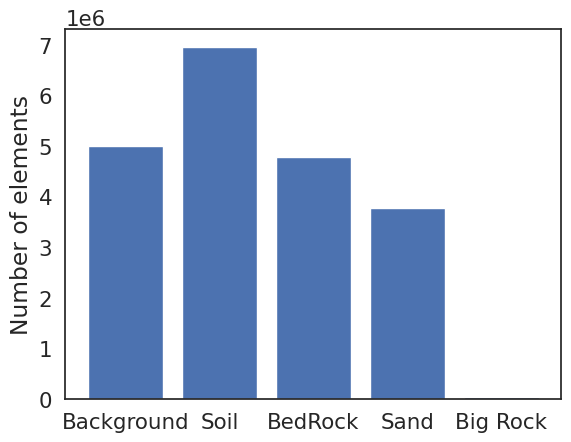

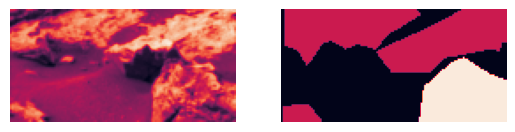

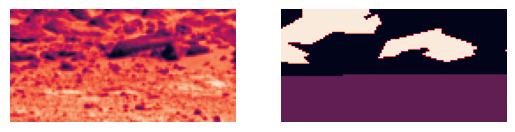

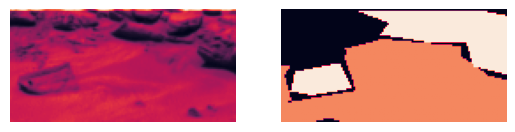

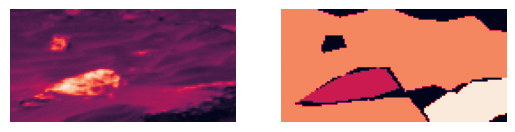

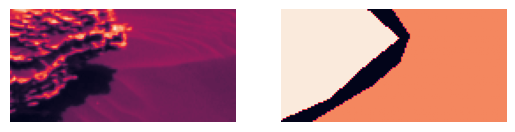

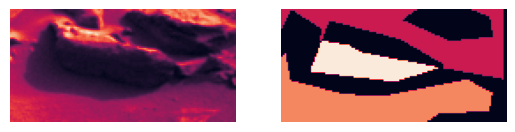

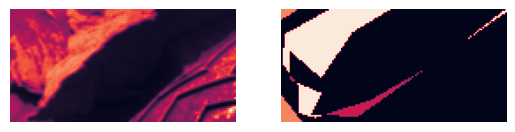

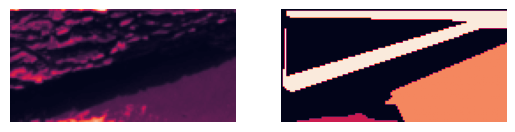

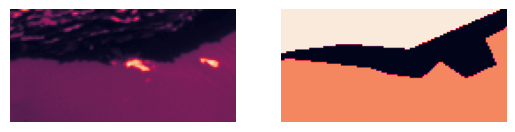

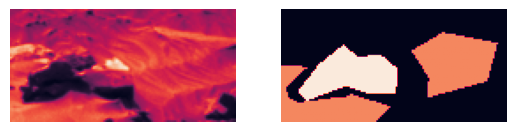

In [4]:
y_train_one_hot = tfk.utils.to_categorical(y_train, num_classes=5)
sum = tf.reduce_sum(y_train_one_hot, axis=[0,1,2])


values = [sum[0].numpy(), sum[1].numpy(), sum[2].numpy(), sum[3].numpy(), sum[4].numpy()]
names = ['Background', 'Soil', 'BedRock', 'Sand', 'Big Rock' ]

plt.bar(names, values)
plt.ylabel('Number of elements')

countPixelxClass = tf.reduce_sum(y_train_one_hot, axis=[1,2]) #vector (2505, 5) es. count[0,0] : total number of pixel with label 0 in the first img

idxBigRock = []
threshold = 0.1 # 10% of pixel of big rock

for i in range(y_train.shape[0]):
  if (countPixelxClass[i,4] / tf.reduce_sum(countPixelxClass[i,:]) > threshold):
    idxBigRock.append(i)

for i in idxBigRock:
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(X_train[i])
  plt.axis('off')
  plt.subplot(1,2,2)
  plt.imshow(y_train[i], vmin = 0, vmax = 4)
  plt.axis('off')
  plt.show()


bigRockONLY_img = []
bigRockONLY_mask = []

## MANUAL ZOOM AUGMENTATION (of images above)

- Img. 1

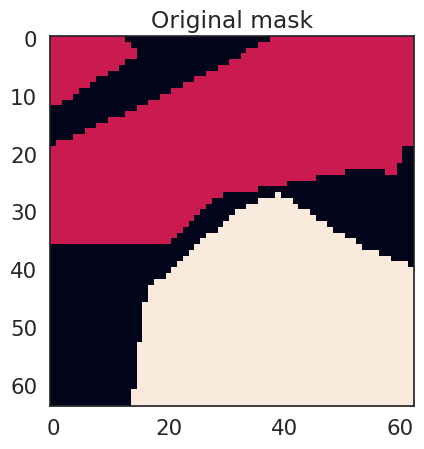

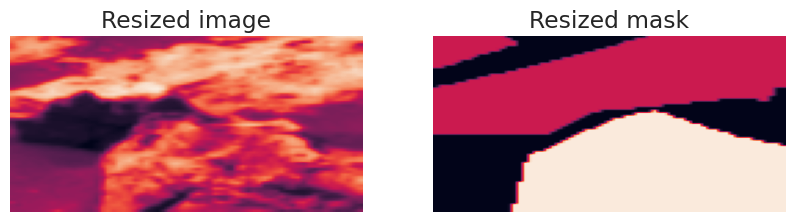

In [5]:
img = X_train[idxBigRock[0]][:,64:127]
mask = y_train[idxBigRock[0]][:,64:127]
resizdMask = tf.image.resize(mask[None,...,None], (64,128))
resizedImg = tf.image.resize(img[None,...,None], (64,128))

plt.title("Original mask")
plt.imshow(mask)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Resized image")
plt.imshow(resizedImg[0,...,0])
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Resized mask")
plt.imshow(resizdMask[0,...,0])
plt.axis('off')
plt.show()

bigRockONLY_img.append(resizedImg[0,...,0])
bigRockONLY_mask.append(resizdMask[0,...,0])

- Img. 2

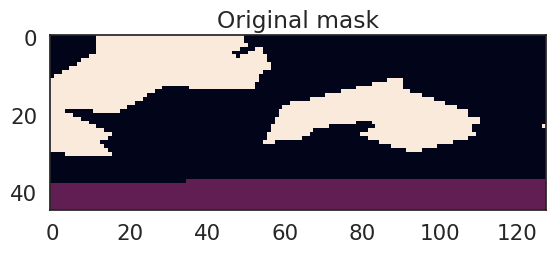

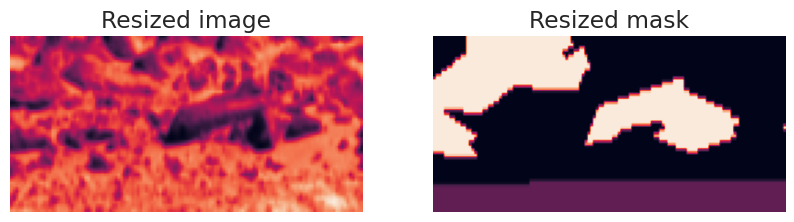

In [6]:
img = X_train[idxBigRock[1]][0:45,:]
mask = y_train[idxBigRock[1]][0:45,:]
resizdMask = tf.image.resize(mask[None,...,None], (64,128))
resizedImg = tf.image.resize(img[None,...,None], (64,128))

plt.title("Original mask")
plt.imshow(mask)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Resized image")
plt.imshow(resizedImg[0,...,0])
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Resized mask")
plt.imshow(resizdMask[0,...,0])
plt.axis('off')
plt.show()

bigRockONLY_img.append(resizedImg[0,...,0])
bigRockONLY_mask.append(resizdMask[0,...,0])

- IMG. 3

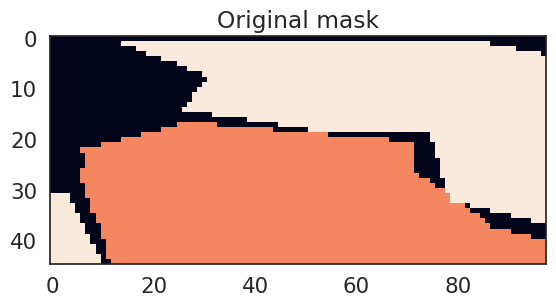

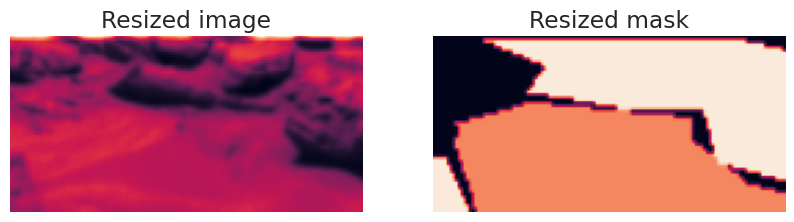

In [7]:
img = X_train[idxBigRock[2]][0:45,30:]
mask = y_train[idxBigRock[2]][0:45,30:]
resizdMask = tf.image.resize(mask[None,...,None], (64,128))
resizedImg = tf.image.resize(img[None,...,None], (64,128))

plt.title("Original mask")
plt.imshow(mask)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Resized image")
plt.imshow(resizedImg[0,...,0])
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Resized mask")
plt.imshow(resizdMask[0,...,0])
plt.axis('off')
plt.show()

bigRockONLY_img.append(resizedImg[0,...,0])
bigRockONLY_mask.append(resizdMask[0,...,0])

- IMG. 4 - Unfeasible zoom

- IMG. 5

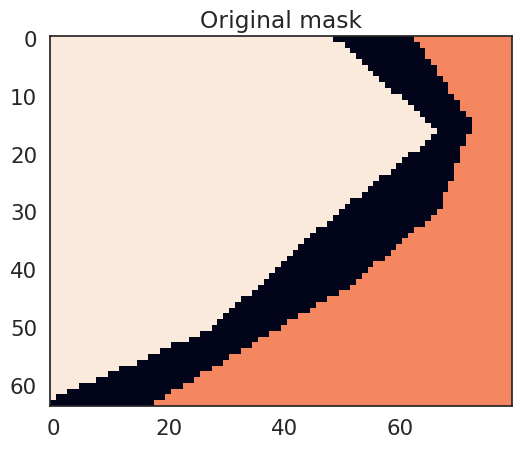

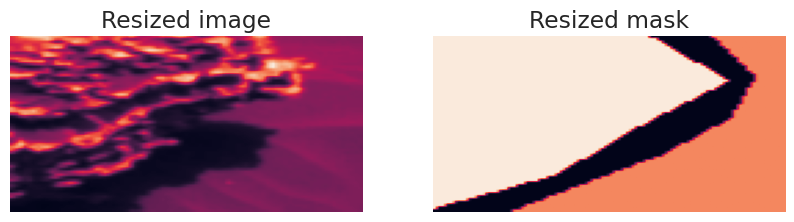

In [8]:
img = X_train[idxBigRock[4]][:,:80]
mask = y_train[idxBigRock[4]][:,:80]
resizdMask = tf.image.resize(mask[None,...,None], (64,128))
resizedImg = tf.image.resize(img[None,...,None], (64,128))

plt.title("Original mask")
plt.imshow(mask)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Resized image")
plt.imshow(resizedImg[0,...,0])
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Resized mask")
plt.imshow(resizdMask[0,...,0])
plt.axis('off')
plt.show()

bigRockONLY_img.append(resizedImg[0,...,0])
bigRockONLY_mask.append(resizdMask[0,...,0])

- IMG. 6 - Unfeasible zoom

- IMG. 7

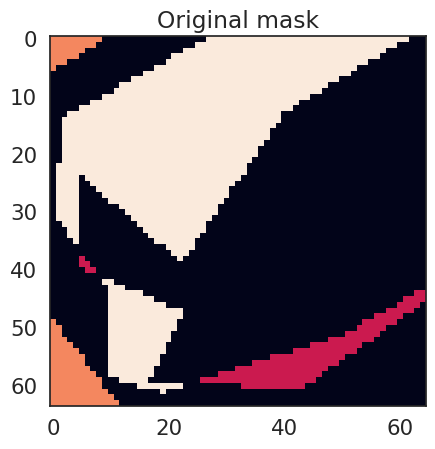

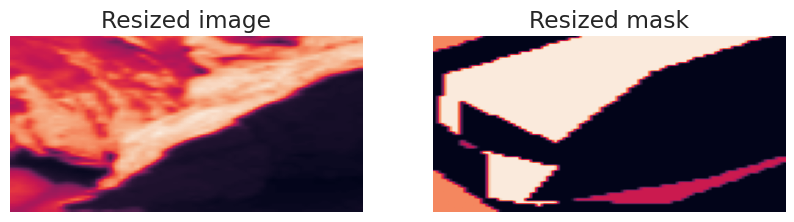

5
5


In [9]:
img = X_train[idxBigRock[6]][:,:65]
mask = y_train[idxBigRock[6]][:,:65]
resizdMask = tf.image.resize(mask[None,...,None], (64,128))
resizedImg = tf.image.resize(img[None,...,None], (64,128))


plt.title("Original mask")
plt.imshow(mask)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Resized image")
plt.imshow(resizedImg[0,...,0])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(resizdMask[0,...,0])
plt.title("Resized mask")
plt.axis('off')
plt.show()

bigRockONLY_img.append(resizedImg[0,...,0])
bigRockONLY_mask.append(resizdMask[0,...,0])

print(len(bigRockONLY_img))
print(len(bigRockONLY_mask))

- IMG. 8 - Unfeasible zoom

- IMG. 9

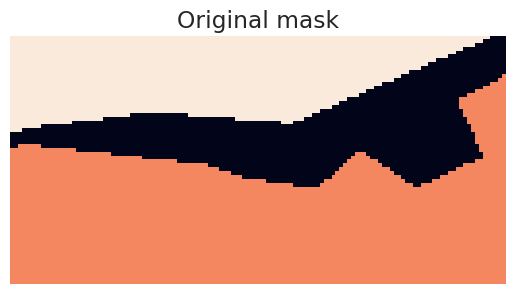

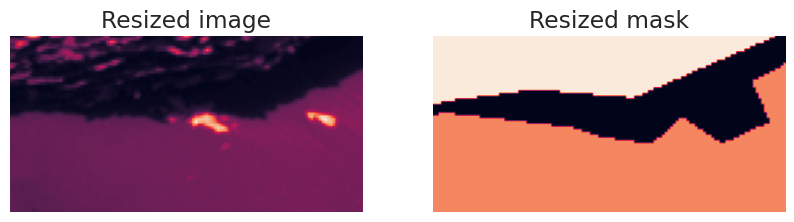

In [10]:
img = X_train[idxBigRock[8]][:80,]
mask = y_train[idxBigRock[8]][:80,]

resizdMask = tf.image.resize(mask[None,...,None], (64,128))
resizedImg = tf.image.resize(img[None,...,None], (64,128))

plt.title("Original mask")
plt.imshow(mask)
plt.axis('off')

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(resizedImg[0,...,0])
plt.title("Resized image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(resizdMask[0,...,0])
plt.title("Resized mask")
plt.axis('off')
plt.show()

bigRockONLY_img.append(resizedImg[0,...,0])
bigRockONLY_mask.append(resizdMask[0,...,0])

- IMG. 10 - Unfeasible zoom

## COLLECTING AND AUGMENTATION

In [11]:
bigRockONLY_img = np.array(bigRockONLY_img)
bigRockONLY_mask = np.array(bigRockONLY_mask)

print(bigRockONLY_img.shape)
print(bigRockONLY_mask.shape)

(6, 64, 128)
(6, 64, 128)


In [12]:
bigRock = X_train[idxBigRock]
bigRockLabel = y_train[idxBigRock]

print(bigRock.shape)
print(bigRockLabel.shape)

(10, 64, 128)
(10, 64, 128)


In [13]:
bigRock = np.append(bigRock, bigRockONLY_img, axis=0)
bigRockLabel = np.append(bigRockLabel, bigRockONLY_mask, axis=0)

print(bigRock.shape)
print(bigRockLabel.shape)

(16, 64, 128)
(16, 64, 128)


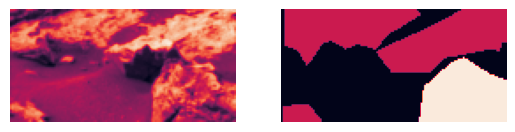

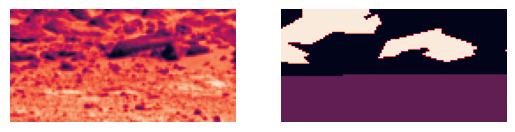

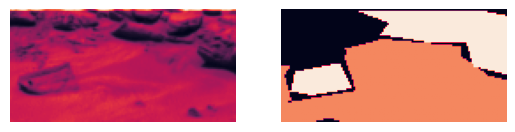

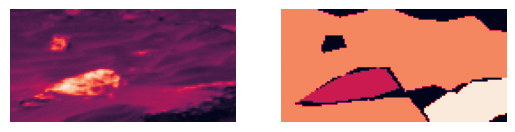

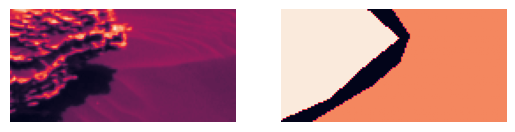

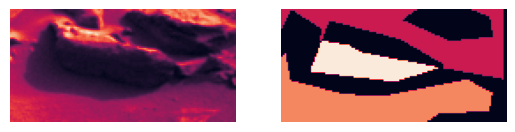

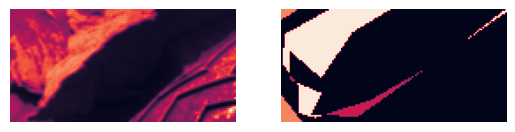

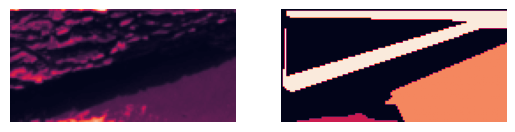

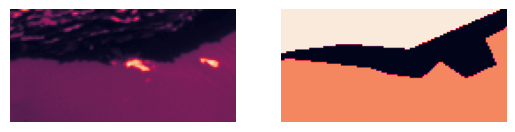

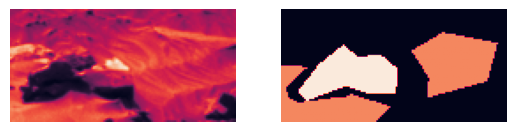

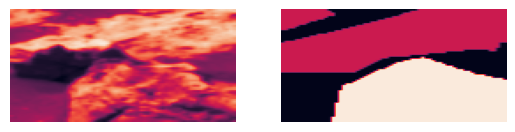

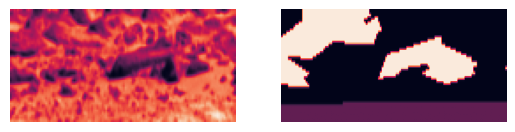

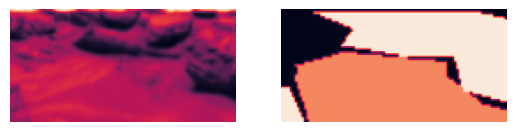

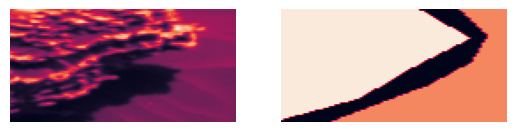

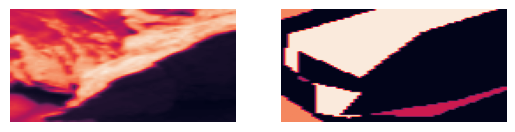

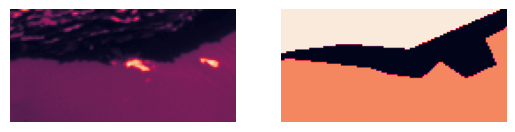

In [14]:
for i in range(bigRock.shape[0]):
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(bigRock[i])
  plt.axis('off')
  plt.subplot(1,2,2)
  plt.imshow(bigRockLabel[i], vmin = 0, vmax = 4)
  plt.axis('off')
  plt.show()

# Albumentation

In [15]:
import albumentations as A

#bigRock = X_train[idxBigRock]
#bigRockLabel = y_train[idxBigRock]

print(bigRock.shape)
print(bigRockLabel.shape)

for i in range(6):
  bigRock = np.append(bigRock, bigRock, axis=0)
  bigRockLabel = np.append(bigRockLabel, bigRockLabel, axis=0)

print(bigRock.shape)
print(bigRockLabel.shape)

GeometricTrasform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=(-180,180)),
])
img = []
masks = []

for i in range(bigRock.shape[0]):
  transformed = GeometricTrasform(image=bigRock[i], mask=bigRockLabel[i])
  #print(transformed['image'].shape)
  img.append(transformed['image'])
  masks.append(transformed['mask'])

bigRock = np.array(img)
bigRockLabel = np.array(masks)

(16, 64, 128)
(16, 64, 128)
(1024, 64, 128)
(1024, 64, 128)


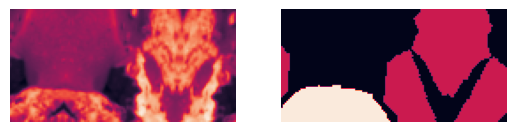

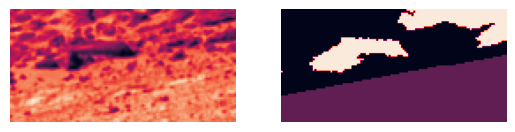

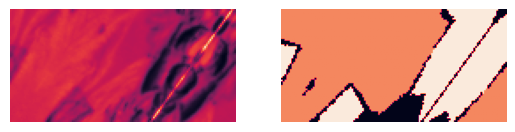

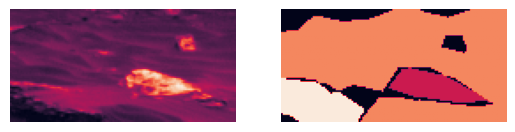

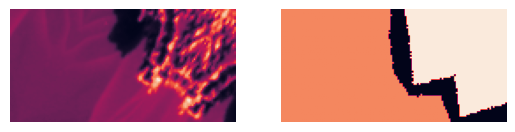

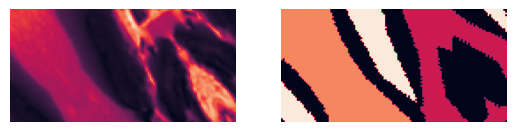

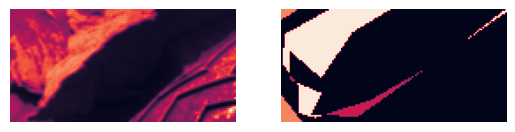

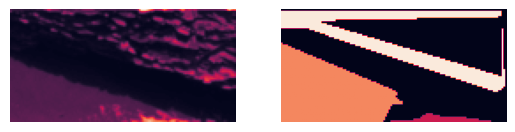

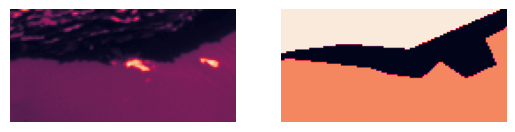

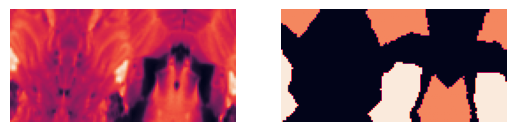

In [16]:
for i in range(10):
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(bigRock[i])
  plt.axis('off')
  plt.subplot(1,2,2)
  plt.imshow(bigRockLabel[i], vmin = 0, vmax = 4)
  plt.axis('off')
  plt.show()

In [17]:
X_train = np.append(X_train, bigRock, axis=0)
y_train = np.append(y_train, bigRockLabel, axis=0)

np.savez_compressed("Datasets/Dataset_BigRock_Augmented.npz", training_set=(X_train, y_train), test_set=X_test)